In [1]:
import os
import numpy
import pandas
import json
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import time

text_stemmer = PorterStemmer()
tfid_vectorizer = TfidfVectorizer(stop_words='english')

In [2]:
# Given a column from the dataset, pulls the given key and returns a list of strings from each row.
# Can be all instances, or limited to an item_count. Replaces all spaces between words.
def normalize_column(json_data, column_key, item_count=-1):
    my_obj = json.loads(json_data)
    end_index = len(my_obj) if item_count <= 0 else item_count
    data = [re.sub(r'\s+', '', item[column_key]) for item in my_obj[:end_index]]
    return data


# Pulls the name of the "Director" job for each row and replaces all spaces between words.
def pluck_director(json_data):
    my_obj = json.loads(json_data)
    director = [re.sub(r'\s+', '', item["name"]) for item in my_obj if item["job"] == "Director"]
    return director


# Reduce and normalize wod instances to their base root form.
def stem_text(text):
    return " ".join(map(text_stemmer.stem, text.split()))

In [3]:
movies_data_frame = pandas.read_csv('movies-archive-data/tmdb_5000_movies.csv')
credits_data_frame = pandas.read_csv('movies-archive-data/tmdb_5000_credits.csv')
# combine the datasets on "title"
movies = movies_data_frame.merge(credits_data_frame, on="title")
# use these columns
movies = movies[["movie_id", "title", "overview", "genres", "keywords", "cast", "crew"]]
# remove duplicates
movies.dropna(inplace=True)
movies.drop_duplicates(subset=['movie_id'], keep='first', inplace=True)
movies.duplicated().sum()

np.int64(0)

In [4]:
# normalize these objects from objects to lists of plucked values
movies["genres"] = movies["genres"].apply(lambda json_data: normalize_column(json_data, "name"))
movies["keywords"] = movies["keywords"].apply(lambda json_data: normalize_column(json_data, "name"))
movies["cast"] = movies["cast"].apply(lambda json_data: normalize_column(json_data, "name", 3))
movies["crew"] = movies["crew"].apply(pluck_director)
movies["overview"] = movies["overview"].apply(lambda str_data: str_data.split())

# classify the data
training_data = movies[["movie_id", "title"]]
training_data["stemmed"] = (
        movies["overview"] + movies["genres"] + movies["keywords"] + movies["cast"] + movies["crew"]
).apply(lambda str_text: " ".join(str_text).lower())
training_data["stemmed"] = training_data["stemmed"].apply(stem_text)

tfid_matrix = tfid_vectorizer.fit_transform(training_data["stemmed"]).toarray()
nn = NearestNeighbors(n_neighbors=6, metric='cosine')
nearest_neighbors = nn.fit(tfid_matrix)

C:\Users\thisi\AppData\Local\Temp\ipykernel_28928\1556403138.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data["stemmed"] = (
C:\Users\thisi\AppData\Local\Temp\ipykernel_28928\1556403138.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data["stemmed"] = training_data["stemmed"].apply(stem_text)


In [5]:
def get_recommendations(movie_title):
    try:
        index = training_data[training_data['title'] == movie_title].index[0]
        query_vector = numpy.array([tfid_matrix[index]])
        distances, indices = nearest_neighbors.kneighbors(query_vector)

        # Using list comprehension to collect recommendations
        recommendations = [
            {
                'movie_index': int(training_data.iloc[i]['movie_id']),
                # Assuming 'movie_id' is the column name
                'title': training_data.iloc[i]['title'],
                'movie_id': int(training_data.iloc[i]['movie_id'])
            }
            for i in indices[0][1:6]  # Exclude the first index (itself) and take the top 5 recommendations
        ]

        return recommendations
    except IndexError:
        return []

In [6]:
get_recommendations('Spider-Man')

[{'movie_index': 559, 'title': 'Spider-Man 3', 'movie_id': 559},
 {'movie_index': 558, 'title': 'Spider-Man 2', 'movie_id': 558},
 {'movie_index': 6488, 'title': 'Arachnophobia', 'movie_id': 6488},
 {'movie_index': 102382,
  'title': 'The Amazing Spider-Man 2',
  'movie_id': 102382},
 {'movie_index': 1930, 'title': 'The Amazing Spider-Man', 'movie_id': 1930}]

In [7]:
get_recommendations('GoldenEye')

[{'movie_index': 708, 'title': 'The Living Daylights', 'movie_id': 708},
 {'movie_index': 700, 'title': 'Octopussy', 'movie_id': 700},
 {'movie_index': 667, 'title': 'You Only Live Twice', 'movie_id': 667},
 {'movie_index': 714, 'title': 'Tomorrow Never Dies', 'movie_id': 714},
 {'movie_index': 36669, 'title': 'Die Another Day', 'movie_id': 36669}]

In [8]:
%matplotlib inline
from matplotlib import pyplot

def normalize_column_expanded(json_data, column_key, item_count=-1):
    my_obj = json.loads(json_data)
    end_index = len(my_obj) if item_count <= 0 else item_count
    data = [re.sub(r'\s+', ' ', item[column_key]) for item in my_obj[:end_index]]
    return data

movies = pandas.read_csv('movies-archive-data/tmdb_5000_movies.csv')
credits = pandas.read_csv('movies-archive-data/tmdb_5000_credits.csv')
original_data = movies.merge(credits, on='title')
original_data["keywords"] = original_data["keywords"].apply(lambda json_data: normalize_column_expanded(json_data, "name"))
original_data["genres"] = original_data["genres"].apply(lambda json_data: normalize_column_expanded(json_data, "name"))

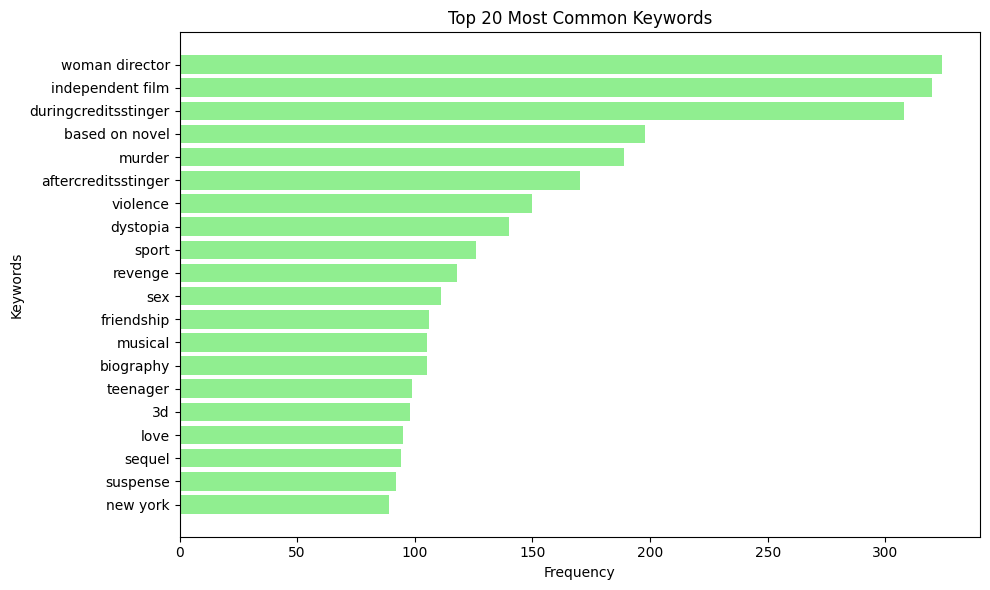

In [9]:
from collections import Counter

all_keywords = original_data['keywords'].explode().dropna()
keyword_counts = Counter(all_keywords)
common_keywords = keyword_counts.most_common(20)

pyplot.figure(figsize=(10, 6))
pyplot.barh([keyword[0] for keyword in common_keywords], [keyword[1] for keyword in common_keywords], color='lightgreen')
pyplot.title('Top 20 Most Common Keywords')
pyplot.xlabel('Frequency')
pyplot.ylabel('Keywords')
pyplot.gca().invert_yaxis()  # Invert y-axis to show most common keywords at the top
pyplot.tight_layout()
pyplot.show()

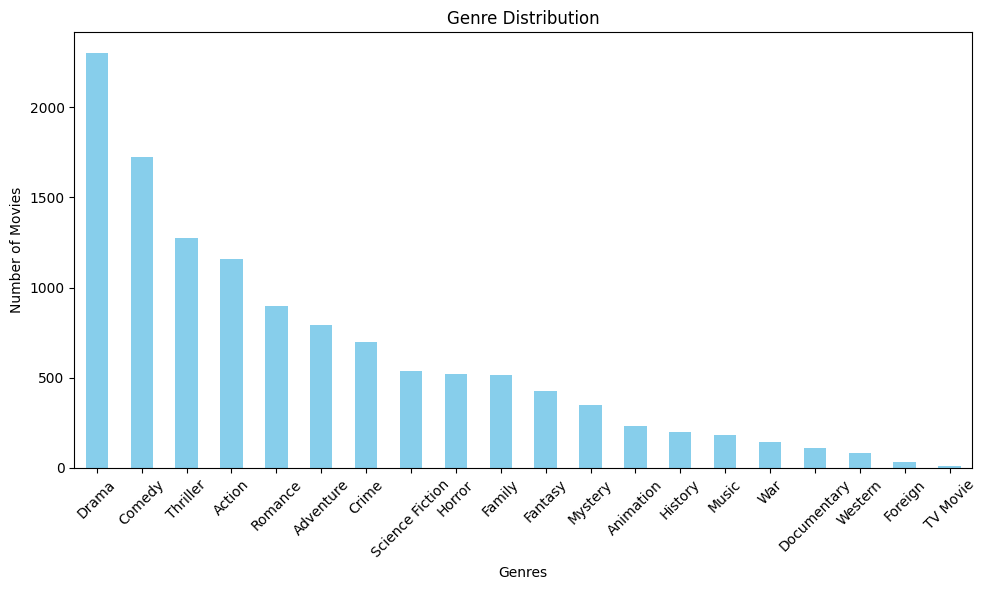

In [10]:
genre_counts = original_data['genres'].explode().value_counts()
pyplot.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
pyplot.title('Genre Distribution')
pyplot.xlabel('Genres')
pyplot.ylabel('Number of Movies')
pyplot.xticks(rotation=45)
pyplot.tight_layout()
pyplot.show()

In [11]:
# Evauluate the algorithm

from sklearn.metrics import precision_score, recall_score, f1_score
# Mapping movie titles to their indices in the DataFrame
title_to_index = {title: idx for idx, title in enumerate(training_data['title'])}
num_movies = len(training_data)
ground_truth_labels = numpy.zeros((num_movies, num_movies))
truth_table_predictions = numpy.zeros((num_movies, num_movies))

# These groups are expected to be mutually exclusive for when the top 5 recommendations come back
symmetric_relations = [
    [
        "Spider-Man", "Spider-Man 2", "Spider-Man 3",
        "The Amazing Spider-Man", "The Amazing Spider-Man 2"
    ],
    [
        "Batman", "The Dark Knight", "The Dark Knight Rises", "Batman: The Dark Knight Returns, Part 2",
        "Batman Begins", "Batman & Robin", "Batman Forever", "Batman Returns"
    ],
    [
        "Pirates of the Caribbean: Dead Man's Chest", "Pirates of the Caribbean: On Stranger Tides",
        "Pirates of the Caribbean: The Curse of the Black Pearl", "Pirates of the Caribbean: At World's End"
    ],
    [
        "Star Trek III: The Search for Spock", "Star Trek II: The Wrath of Khan", "Star Trek: First Contact",
        "Star Trek: Generations", "Star Trek: The Motion Picture", "Star Trek V: The Final Frontier",
        "Star Trek VI: The Undiscovered Country", "Star Trek IV: The Voyage Home", "Star Trek Into Darkness",
        "Star Trek: Insurrection", "Star Trek: Nemesis", "Star Trek Beyond", "Star Trek"
    ],
    [
        "GoldenEye", "The World Is Not Enough", "Die Another Day", "Tomorrow Never Dies", "Moonraker",
        "A View to a Kill", "For Your Eyes Only", "Octopussy", "The Spy Who Loved Me", "Live and Let Die",
        "The Man with the Golden Gun", "Goldfinger", "From Russia with Love", "Dr. No", "Never Say Never Again",
        "You Only Live Twice", "Thunderball", "Diamonds Are Forever", "Spectre", "Quantum of Solace", "Skyfall",
        "Casino Royale", "Licence to Kill", "The Living Daylights", "On Her Majesty's Secret Service"
    ]
]

for symmetric_group in symmetric_relations:
    for i in range(len(symmetric_group)):
        for j in range(i + 1, len(symmetric_group)):
            movie1_index = title_to_index[symmetric_group[i]]
            movie2_index = title_to_index[symmetric_group[j]]
            ground_truth_labels[movie1_index, movie2_index] = 1
            ground_truth_labels[movie2_index, movie1_index] = 1  # Reflective relation

print("Ground Labels generated")

for symmetric_group in symmetric_relations:
    # Iterate through each movie in the symmetric group
    for movie_title in symmetric_group:
        # Get the index of the movie in the training data
        searched_movie_index = title_to_index.get(movie_title)

        # Get recommendations for the current movie
        recommendations = get_recommendations(movie_title)
        print(f"got recommendations for {movie_title}")

        # Iterate through recommendations
        for recommendation in recommendations:
            recommendation_title = recommendation["title"]
            recommendation_index = title_to_index.get(recommendation_title)

            # Ensure movie_title is not recommended to itself
            if searched_movie_index != recommendation_index:
                # Set both directions in the truth table to 1
                truth_table_predictions[searched_movie_index, recommendation_index] = 1
                truth_table_predictions[recommendation_index, searched_movie_index] = 1

print("Truth Table generated")

print("Flattening")
y_ground = ground_truth_labels.flatten()
y_predict = truth_table_predictions.flatten()

# Calculate precision, recall, and f1-score
print("Calculating Scores")
start_time = time.time()
precision = precision_score(y_ground, y_predict)
recall = recall_score(y_ground, y_predict)
f1 = f1_score(y_ground, y_predict)
end_time = time.time()

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Time taken: {end_time - start_time:.4f} seconds")

Ground Labels generated
got recommendations for Spider-Man
got recommendations for Spider-Man 2
got recommendations for Spider-Man 3
got recommendations for The Amazing Spider-Man
got recommendations for The Amazing Spider-Man 2
got recommendations for Batman
got recommendations for The Dark Knight
got recommendations for The Dark Knight Rises
got recommendations for Batman: The Dark Knight Returns, Part 2
got recommendations for Batman Begins
got recommendations for Batman & Robin
got recommendations for Batman Forever
got recommendations for Batman Returns
got recommendations for Pirates of the Caribbean: Dead Man's Chest
got recommendations for Pirates of the Caribbean: On Stranger Tides
got recommendations for Pirates of the Caribbean: The Curse of the Black Pearl
got recommendations for Pirates of the Caribbean: At World's End
got recommendations for Star Trek III: The Search for Spock
got recommendations for Star Trek II: The Wrath of Khan
got recommendations for Star Trek: First